In [16]:
#coding: utf-8

#import des modules
#lecture des json
import json 
#affichage des dictionnaires avec idententation
import pprint
pp = pprint.PrettyPrinter(indent=4, )
#librairie des graphes
import networkx as nx
#affichage des graphs
import matplotlib
import matplotlib.pyplot as plt
#calcul
import numpy as np
from itertools import combinations
%matplotlib inline

# Toutes les  versions de l'article 9

Nous allons charger les informations contenues dans le fichier article 9:
* la version originale (qui correspond aux statistiques finales de votes sur l'article)
* les versions complémentaires (soit les 108 modifications additionnelles proposées au vote)
selon la même nomenclature (les versions complémentaires de l'article 9 sont identifiées par le slug de l'article)
elles contiennent un ensemble de votes la modification apportée et un ensemble d'arguments 

#### Une petite explication sur la génération des slugs
Ils servent de clés au dictionnaire de versions:
Notre but étant de rappatrier les votes de chaque versions  pour chaque participant
il faut identifier de quelle version il s'agit.
Ici pour faciliter le travail et comme on peut voir plus haut
la version originale correspond au nom de générique de l'article

Recapitulons:

L'url de la version originale se présente sous cette forme:
```
urlV_0 = "http://www.republique-numerique.fr/projects/projet-de-loi-numerique/consultation/consultation/opinions/section-2-travaux-de-recherche-et-de-statistique/article-9-acces-aux-travaux-de-la-recherche-financee-par-des-fonds-publics"
```
L'url des versions se présentent toujours sous cette formes
```
urlV_add = "http://www.republique-numerique.fr/projects/projet-de-loi-numerique/consultation/consultation/opinions/section-2-travaux-de-recherche-et-de-statistique/article-9-acces-aux-travaux-de-la-recherche-financee-par-des-fonds-publics/versions/mise-a-disposition-systematique-des-resultats-de-la-recherche-financee-par-des-fonds-publics"
```

Le slug (raccourci) est produit de la manière suivante:
* on découpe les urls en morceaux a partir de "/" et on prend le dernier element de la liste de la manière suivante
```
liste_element_url = url.split("/")
slug = liste_element_url[-1]
```
    * vérifions pour la version originale:
```
liste_element_url = urlV_O.split("/")
print(liste_element _url)
slug = liste_element_url[-1]
print(slug)
```
On est censé avoir:
```
>>> ['http:', '', 'www.republique-numerique.fr', 'projects', 'projet-de-loi-numerique', 'consultation', 'consultation', 'opinions', 'section-2-travaux-de-recherche-et-de-statistique', 'article-9-acces-aux-travaux-de-la-recherche-financee-par-des-fonds-publics']
>>>'article-9-acces-aux-travaux-de-la-recherche-financee-par-des-fonds-publics'
```
    * vérifions pour une autre version:
```
liste_element_url = urlV_add.split("/")
print(liste_element _url)
slug = liste_element_url[-1]
print(slug)
```
On est censé avoir:
```
>>> ['http:', '', 'www.republique-numerique.fr', 'projects', 'projet-de-loi-numerique', 'consultation', 'consultation', 'opinions', 'section-2-travaux-de-recherche-et-de-statistique', 'article-9-acces-aux-travaux-de-la-recherche-financee-par-des-fonds-publics', 'versions', 'mise-a-disposition-systematique-des-resultats-de-la-recherche-financee-par-des-fonds-publics']
>>>'mise-a-disposition-systematique-des-resultats-de-la-recherche-financee-par-des-fonds-publics'
```

In [45]:
def load_versions(art_file="article9.json"):
    '''charger l'ensemble des versions de l'article'''
    versions_d = {}
    with open(art_file, "r") as f:
        article9 = json.load(f)
    
    #Pour rappel
    #print article9.keys()
    versions_d[article9["article_link"].split("/")[-1]] = {
                "id": 0,
                "date": article9["created_at"],
                "link": article9["article_link"],
                "slug": article9["article_link"].split("/")[-1],
                "title": article9["article_link"].split("/")[-1].replace("-", " "),
                "text": article9['body'],
                "author": article9["author"],
                "votes":[], 
                "arguments":article9["arguments"], 
                "votes_arguments": [],
                "sources":article9["sources"],
                "votes_sources": [],
                "total_votes": article9["votes_total"],
                #les décomptes de votes sur les arguments ne sont pas disponible dans l'article9
                  # seulement le nombre d'arguments
                "total_arguments_votes": article9["arguments_count"]
               }
    
    versions = article9["versions"]
    
    #on construit une liste de versions
    for i,v in enumerate(versions):
        #pour rappel
        #print v.keys()
        versions_d[v["slug"]] = {"date":v["created_at"],
                "id": i+1,
                "link":v["link"],
                #"slug":v["slug"],
                "title":v["title"],
                "text": v['comment'],
                "author": v["author"],
                "votes":[], 
                "arguments":[], 
                "votes_arguments": [],
                "sources":[],
                "votes_sources": [],
                "total_votes":v["votes_total"],
              #ici il s'agit bien du nombre de votes sur un argument
                "total_arguments_votes": v["arguments_count"]
             }
    print(len(versions_d), "versions de l'article 9")
    return versions_d

In [46]:
#les versions
vs = load_versions("./article_9.json")

109 versions de l'article 9


# Les participants
Nous allons maintenant récupérer l'ensemble de la liste des participants au *projet de loi*

In [18]:
def load_participants():
    #charger les votes des participants
    with open("./participants.json", "r") as f:
        data = json.load(f)
        participants = data["participants"]
    
    participants_d = {}
    for part in participants:
        for k,v in part.items():
            
            participants_d[k] = v["votes"]
        
    print (len(participants_d), "participants sur l'ensemble des articles")
    return participants_d

In [47]:
# les participants
part = load_participants()

21329 participants sur l'ensemble des articles


### Les electeurs de l'article 9

Nous allons dans `update_version`
mettre à jour les version en ajoutant les votes de chaque participants
Mais comme les votes sont organisés par electeurs
nous allons regarder chaque electeur:
    - verifier qu'il a voté pour une des versions de l'article 9
    identifiable par son nom générique 
```
art = "article-9-acces-aux-travaux-de-la-recherche-financee-par-des-fonds-publics"
``` 
    - vérifier pour quelle version il a voté:
    identifiable par le slug (cf. plus haut)
    - vérifier ensuite s'il s'agit d'un vote sur une source argument ou la version elle même
    identifiable par #source-<id> ou #arg-<id> ou s'il n'en a pas il s'agit de la version elle même
    

In [53]:
def update_versions(participants, versions_d, art="article-9-acces-aux-travaux-de-la-recherche-financee-par-des-fonds-publics"):
    #pour chaque participant
    for user, votes in participants.items():
        #pour chaque vote du participants
        for vote in votes:            
            link = vote["link"]
            #a-t-il voté pour notre article?
            if art in link:
                date =  vote["date"]
                opinion = vote["opinion"]
                #pour quelle version?
                slug = link.split("/")[-1]
                
                #est ce qu'on peut découper avec #?
                # = y a t'il une info complémentaire du type #arg #source
                try:
                    #oui: c'est un vote sur un arg ou une source
                    slug, tid = slug.split("#") 
                    #exemple:
                    
                    if "arg-" in tid:
                        #dans notre dictionnaire de référence sur les versions
                        #c'est un argument on stocke dans les votes pour les arguments
                        versions_d[slug]["votes_arguments"].append({"electeur":user,"vote": opinion, "date":date, "id":tid})
                    elif "source-" in tid:
                        #c'est une sources on stocke dans les votes pour les sources
                        versions_d[slug]["votes_sources"].append({"electeur":user,"vote": opinion, "date":date, "id":tid})
                    else:
                        #au cas ou il y aurait un #autrechose mais ne s'applique pas ici
                        print(slug)
                except:
                    #non: c'est donc un vote simple sur une version (originale ou autre)
                    versions_d[slug]["votes"].append({"electeur":user,"vote": opinion, "date":date})
    
    return versions_d
    

Ici il s'agit d'une simple fonction pour faciliter les statistiques 
et pour ne garder que ce qui nous interesse on verra ici que on ne s'intéresse qu'aux votes sur les versions

Petit rappel de repartition des votes par types:
    * votes sur les versions
    * votes sur les arguments de chaque versions
    * votes sur les sources de chaque versions

Rangés dans des listes qui contiennent la date, l'electeur, le vote et son id unique
mis à plat dans `load_votes()` dans des listes de votes.

In [58]:
#mise à jour des versions en intégrants les votes des participants
vs = update_versions(part, vs)


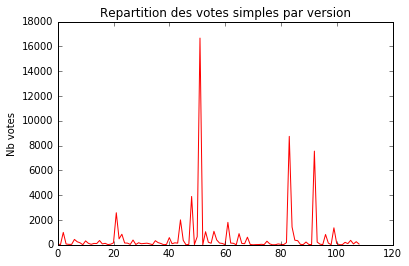

In [60]:
### Vérifions donc la repartition des votes simple par version

def show_nb_votes_by_versions(vs):
    #for k,v in vs.items():
    #    print(len(v["votes"]),"votes sur la version:" , k )
    N = len(vs)
    votes_nb = [len(v["votes"])  for v in vs.values()]
    
    plt.title("Repartition des votes simples par version")
    plt.ylabel('Nb votes')
    #pylab.xlim([0,108])
    #pylab.xlim([0,N])
    plt.plot(votes_nb,color='r')

    plt.show()
    
    return
show_nb_votes_by_versions(vs)

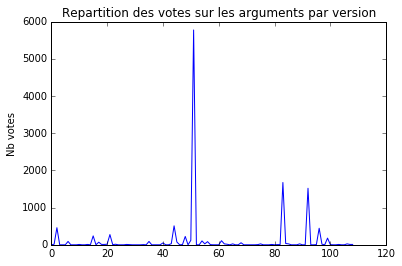

In [61]:
#verifions maintenant les votes par arguments
def show_nb_votes_args_by_versions(vs):
    #for k,v in vs.items():
    #    print(len(v["votes"]),"votes sur la version:" , k )
    N = len(vs)
    votes_nb = [len(v["votes_arguments"])  for v in vs.values()]
    
    plt.title("Repartition des votes sur les arguments par version")
    plt.ylabel('Nb votes')
    #pylab.xlim([0,108])
    #pylab.xlim([0,N])
    plt.plot(votes_nb,color='b')

    plt.show()
    
    return
show_nb_votes_args_by_versions(vs)

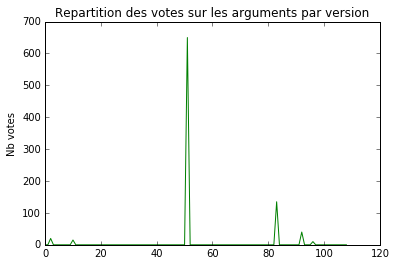

In [63]:
#verifions maintenant les votes sur les sources pour chaque version
def show_nb_votes_args_by_versions(vs):
    #for k,v in vs.items():
    #    print(len(v["votes"]),"votes sur la version:" , k )
    N = len(vs)
    votes_nb = [len(v["votes_sources"])  for v in vs.values()]
    
    plt.title("Repartition des votes sur les sourcess par version")
    plt.ylabel('Nb votes')
    #pylab.xlim([0,108])
    #pylab.xlim([0,N])
    plt.plot(votes_nb,color='g')

    plt.show()
    
    return
show_nb_votes_args_by_versions(vs)

On voit donc une modification particulière a cristallisé les réactions des électeurs entrainant un vote massif
aussi bien sur les arguments, les sources utilisées que les opinions simples (pour, contre, neutre) 

Elles correspondent aussi au moment fort de la consultation. 
Voyons donc le nombre de votes total


(16670, 'votes sur', 'article-9-acces-aux-travaux-de-la-recherche-financee-par-des-fonds-publics')
(5775, 'votes sur les arguments de', 'article-9-acces-aux-travaux-de-la-recherche-financee-par-des-fonds-publics')
(650, 'votes sur les sources de', 'article-9-acces-aux-travaux-de-la-recherche-financee-par-des-fonds-publics')


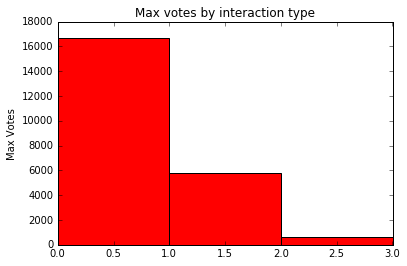

In [112]:
votes_simples = [(len(v["votes"]),"votes sur", k)  for k, v in vs.items()]
print(max(votes_simples))
votes_args = [(len(v["votes_arguments"]),"votes sur les arguments de", k)  for k, v in vs.items()]
print(max(votes_args))

votes_sources = [(len(v["votes_sources"]),"votes sur les sources de", k)  for k, v in vs.items()]
print(max(votes_sources))

fig = plt.figure()

x = [0, 1, 2]
y = [max(votes_simples)[0], max(votes_args)[0], max(votes_sources)[0]]
#plt.hist(y)
#from numpy.random import normal
#gaussian_numbers = normal(size=1000)
#print(gaussian_numbers)
#plt.hist(y, 50, histtype="stepfilled", alpha=.7)
fig, ax = plt.subplots()
rects1 = ax.bar(x, y, 1, color='r')
# add some text for labels, title and axes ticks
ax.set_ylabel('Max Votes')
ax.set_title('Max votes by interaction type')
#ax.set_xticks(0.35)
#ax.set_xticklabels(['Votes', 'Args', 'Sources'])
plt.show()

#ax.legend((rects1[0], rects2[0]), ('Men', 'Women'))

#votes_max = [max(votes_simples), max(votes_args), max(votes_sources)]
    
#plt.title("Maximum du nb de votes")
#plt.ylabel('Nb votes')
#plt.xlabel(["votes simple", "votes args", "votes sources"])
    #pylab.xlim([0,108])
    #pylab.xlim([0,N])
#plt.hist(votes_nb)

plt.show()
    

On voit bien ici qu'on est loin des votes comptabilisés au final sur cet article


## Concentrons nous sur les electeurs de l'article 9

Maintenant que nous avons nos votes par versions 
nous allons charger le **détail** des votes pour l\'article9 qui nous intéresse ici soit:
* l'électeur 
* la version 
* le vote
* la date
 aussi bien sur l'original que sur les modifications proposées

In [20]:
def load_votes(participants,art ="article-9-acces-aux-travaux-de-la-recherche-financee-par-des-fonds-publics"):
    #charger les votes des electeurs de l'article 9
    votes_v = []
    votes_args = []
    votes_src = []
    for user, votes in participants.items():
        for vote in votes:
            link = vote["link"]
            if art in link:
                date =  vote["date"]
                opinion = vote["opinion"]
                slug = link.split("/")[-1]
                try:
                    slug, tid = slug.split("#") 
                    if "arg-" in tid:
                        votes_args.append({"electeur":user,"vote": opinion, "slug":slug, "date":date, "id":tid})
                    elif "source-" in tid:
                        votes_src.append({"electeur":user,"vote": opinion, "slug":slug, "date":date, "id":tid})
                    else:
                        print(slug)
                except:
                    votes_v.append({"electeur":user,"vote": opinion, "slug":slug, "date":date})
            
    print(len(votes_v),"votes", len(votes_args),"votes sur les arg", len(votes_src), "votes sur les sources")
    return votes_v, votes_args, votes_src
    

# Filter top_electeur
* Premier objectif : calculer combien de fois un electeur a voté pour l'article (c'est à dire sur toutes les versions)

On découvre en passant que les votes comptabilisés par le gouvernement ne prend en compte que le nombre de **votes de la versions originale**. 

La proposition d'amender un article et de voter pour cette version de texte n'a eu une aucune incidence sur le choix de réécriture des articles ni sur le droit de réponse ouvert par le gouvernement sur la base des articles les plus votés.
Les systèmes de votes multiples (article, amendements, arguments) n'est donc pas intégré au processus de validation de consultation final.

In [38]:
def count_votes_electeurs(votes):
    #ici on compte simplement le nombre de nom d'electeur dans  la liste de votes 
    #soit pour chaque electeur son nombre de vote total peut importe le type de vote
    from collections import Counter, defaultdict
    electeur_nb_votes = dict(Counter([data["electeur"] for data in votes]))
    nb_votes_distrib = defaultdict.fromkeys(electeur_nb_votes.values(), 0)
    for electeur, votes in electeur_nb_votes.items():
        nb_votes_distrib[votes]+=1
        
    #print(electeur_nb_votes)
    print(dict(nb_votes_distrib)
    #import operator
    #nb_votes = sorted(voteurs.items(), key=operator.itemgetter(1))
    #print(nb_votes)
    #nb_votes_stats = {k:len(v) for k,v in nb_votes_d.items()}
    #print(sorted(nb_votes_stats.items()))
    '''
    from collections import Counter, defaultdict
    #ici je crée la liste des electeurs uniques qui ont votés
    electeur_names = list(set([v["electeur"] for v in votes]))
    #ici je crée un dictionnaire pour chaque electeur qui contient une liste vide
    electeurs_d = defaultdict.fromkeys(electeur_names, [])
    
    
    #On déroule la liste des votes pour rappatrier le vote de chacun 
    for vote in votes:
        # chaque vote est un dictionnaire
        #qui contient le nom de l'electeur + ...
        # vote = {"electeur": "cdequatrebarbes", "opinion":1, "date": XXX, "slug": XXX, "id":5}
        #pour chaque electeur on lui ajoute son vote (ici un type de vote choisi (cf.votes))
        electeurs_d[vote["electeur"]].append(vote)
    '''
    
count_votes_electeurs(votes)

defaultdict(None, {1: 3043, 2: 1359, 3: 488, 4: 263, 5: 117, 6: 95, 7: 63, 8: 48, 9: 33, 10: 21, 11: 22, 12: 14, 13: 12, 14: 10, 15: 5, 16: 4, 17: 2, 18: 3, 19: 4, 20: 2, 21: 1, 22: 1, 88: 1, 25: 2, 26: 1, 28: 1, 30: 1, 32: 1, 33: 2, 35: 4, 36: 2, 38: 1, 39: 2, 80: 1, 41: 1, 42: 2, 43: 1, 44: 1, 55: 1})


* Deuxième objectif: qui sont les electeurs les plus actifs? 

Si on analyse la répartition des electeurs / X le nombre de votes, on se rend compte comme la plupart des datasets que 80% des electeurs ont compté pour moins de 20 % des votes

Ici on filtre les electeurs les plus actifs selon un nb_votes_min
qui veut dire l'electeur doit avoir voté au moins X fois

On génère donc un nouveau dictionnaire de référence d'électeurs qui correspond aux électeurs ayant votés au moins X fois

In [22]:
def filter_top_electeurs(votes, nb_votes_min):
    from collections import Counter, defaultdict
    #ici je crée la liste des electeurs uniques qui ont votés
    electeur_names = list(set([v["electeur"] for v in votes]))
    #ici je crée un dictionnaire pour chaque electeur qui contient une liste vide
    electeurs_d = defaultdict.fromkeys(electeur_names, [])
    
    #On déroule la liste des votes 
    for vote in votes:
        # chaque vote est un dictionnaire
        #qui contient le nom de l'electeur + ...
        # vote = {"electeur": "cdequatrebarbes", "opinion":1, "date": XXX, "slug": XXX, "id":5}
        #pour chaque electeur on lui ajoute son vote (ici un type de vote choisi (cf.votes))
        electeurs_d[vote["electeur"]].append(vote)
    
    #ici on compte simplement le nombre de nom dans la liste 
    f = Counter([data["electeur"] for data in votes])
    nb_votes_top_users = 0
    #f["vincentreverdy"] x fois dans la liste
    
    for name,nb_votes in f.items():
        if nb_votes < nb_votes_min:
            del electeurs_d[name]
            nb_votes_top_users +=nb_votes
    #Quelques stats pour justifier le seuil de participation
    nb_top_users =  len(electeurs_d)
    #on a aussi nb_votes_top_users
    nb_votes_total = len(votes)
    
    nb_total_users = len(electeur_names)
    
    
    print ("TOTAL ===============")
    print ("Nb Total de votes sur les versions", str(nb_votes_total))
    print ("Nb Total d'electeurs sur les versions", str(nb_total_users))
    print ("TOP USERS ===============")
    print ("Nb d'electeur ayant votés", nb_votes_min, "fois:", nb_top_users)
    print ("Nb de votes des electeurs ayant votés", nb_votes_min, "fois:", nb_votes_top_users)
    print ("POURCENTAGE ===============")
    print ("Ces electeurs ayant votés au moins", nb_votes_min, "fois\n représentent:")
    part_users = float(float(nb_top_users)/nb_total_users)*100
    part_votes = (float(nb_votes_top_users)/nb_votes_total)*100
    print ("- % des electeurs:", part_users)
    print ("- % des votes:",part_votes)
    return electeurs_d
    

In [23]:
## Calc_similarity
#on calcule la similarité entre les top_electeurs sur l'ensemble des versions
#on definit grace au SEUIL que les electeurs sont similaires
#a partir du moment où ils ont votés x fois sur la même version


In [11]:
def calc_similarity(electeurs, versions_d, nb_votes_simil=0):
    #Rappel:definition du score de similarité
    #un electeur est similaire à un autre
    #dans la mesure où ils ont voté X fois de la même manière
    
    from itertools import combinations
    votes_by_version = {}
    #pour chaque version
    for v, k in versions_d.items():
        #j'ajoute les votes de chaque utilisateur:
        #versionA = [{"user x": 1}, {"user Y": -1}, {"user B": 0}]
        votes_by_version[v] = {e["electeur"]:e["vote"] for e in k["votes"]}
    
    #mon score de similarité est un dictionnaire de couple possible
    #avec un score à 0 au début
    similarity_score = {}
    #tous les couples uniques possibles 
    #(sans permutation c'est à dire sans distinction d'orientation)
    # soit pour une combinaison de couple(2)
    #["A","B", "C"]
    #combo = [(A, B), (A,C), (B,C)]
    #et non pas
    #permut = [(A, B),(B,A), (A,C),(C,A), (B,C), (C,B)]
    #notre graphe sera non dirigée le sens n'a aucune importance
    #vu qu'il s'agit de savoir s'ils ont un comportement identique dans leur vote
    for couple in combinations(electeurs.keys(), 2):
        userA, userB = couple
        
        similarity_score[couple] = 0
        #pour chaque version
        for k,v in votes_by_version.items():
            #verifier si A et B ont tous les deux votés pour cette version
            if userA in v.keys() and userB in v.keys():
                #si A a voté comme B
                if v[userA] == v[userB]:
                    #alors on ajoute 1
                    similarity_score[couple] += 1
                
    #on recupère nos couples de potes si leur score de similarité
    # est superieur ou égal au nb de votes similaires nb_votes_simil
    return {couple:score for couple,score in similarity_score.items() if score >= nb_votes_simil}


In [24]:
def build_histogram(versions_nb):
    import pylab
    %matplotlib inline
    N = len(versions_nb)
    votes_infos = [v["total_votes"]  for v in versions_nb.values()]
    
    args_infos = [v["total_arguments_votes"]  for v in versions_nb.values()]
    plt.title("Historique des votes et votes d'arguments par version")
    plt.ylabel('Nb votes')
    #pylab.xlim([0,108])
    plt.plot(votes_infos,color='r')
    plt.plot(args_infos,color='b')

    plt.show()
    plt.title("historique des votes des arguments par version")
    plt.ylabel('Nb votes sur les arguments')
    pylab.xlim([0,len(versions_nb)])
    plt.plot(args_infos,color='b')
    plt.show()
    return

In [31]:
def build_distrib(freq):
    '''build repartition votes'''
    N = len(freq)
    print(sorted(freq.items()))
    plt.title("Nombre de votes par auteurs")
    plt.plot(sorted(freq.values()),color='r')
    plt.show()
    plt.title("historique des votes des arguments par version")
    plt.ylabel('Nb votes sur les arguments')
    pylab.xlim([0,N])
    pylab.ylim([1,50])
    plt.show()
    return 

In [32]:
def build_dataset(top_electeurs, vs, SEUIL=1):
    similar_couple = calc_similarity(top_electeurs, vs, SEUIL=SEUIL)
    with open("families.csv", "w") as f:
        f.write("userA\tuserB\tscore\n")
        for couple, score in similar_couple.items():
            userA, userB = couple
            f.write("\t".join([userA, userB, str(score)])+"\n")
    return similar_couple

In [33]:
def build_graph(simil, top_users, SEUIL, name="test.gexf"):
    #instancier mon graph non dirigé
    g = nx.Graph()
    #spatialisation selon l'algo Fruchterman Reingold
    pos = nx.spring_layout(g)
    #pour chaque user du couple
    for couple, score in simil.keys():
        #j'ajoute un noeud 
        #qui a pour poids le nombre de votes de l'utilisateur
        g.add_node(couple[0], nb_votes=str(len(top_users[couple[0]])))
        g.add_node(couple[1], nb_votes=str(len(top_users[couple[1]])))
        #j'ajoute le lien entre les noeuds
        #qui a pour poids le score de similarité
        g.add_edge(couple[0], couple[1], score=str(score))
    
    for node in nx.isolates(g):
        print ("Isolé", node)
        g.remove_node(node)
    #name = "graph_similarity_TOP%i_SCORE_%i.gexf" %(SEUIL)
    nx.write_gexf(g, name)
    nx.draw(g)
    plt.show()
    return

In [34]:
def build_graph_from_db(top_users, SEUIL, ):
    name = "./carto_%i_%i.gexf" %SEUIL
    import csv
    import networkx as nx
    g = nx.Graph()
    pos = nx.spring_layout(g)
    with open("families.csv", "r") as f:
        r = csv.reader(f, delimiter="\t")
        for i, row in enumerate(r):
            if i == 0:
                pass
            else:
                if int(row[2]) >= SEUIL[1]:
                    if (row[0] in top_users.keys() & row[1] in top_users.keys()):
                        poid_userA = len(top_users[row[0]])
                        poid_userB = len(top_users[row[1]])
                    
                        g.add_node(row[0], votes_nb=len(top_users[row[0]]))
                        g.add_node(row[1], votes_nb=len(top_users[row[1]]))
                        g.add_edge(row[0], row[1], score=row[2])
                    else:
                        print(row[0], row[1], row[2])
                    
                        
    
    print (name)
    nx.write_gexf(g, name)
    return name
                    

In [ ]:
if __name__ == "__main__":
    #versions_d = build_versions()
    #votes, electeurs_d = load_electeurs()
    
    part = load_participants()
    vs = update_versions(part, vs)
    votes, vvargs, vsources= load_votes(part)
    build_histogram(vs)
    build_distrib(vs)
    
    #SEUIL
    SEUIL = (10, 3)
    #seuil 0 : Qui on considère comme top_user (i.i combine de votes minimum?, 
    #seuil1: A partir de combien de votes on peut dire qu'ils ont un comportement similaire?
    #Top electeurs (ont votes x fois au minimum)
    top_electeurs = filter_top_electeurs(votes, SEUIL[0])
    print(len(top_electeurs))
    #On stocke les couples similaires 
    #(les couples de top_electeur ont votés 1 fois pareil au minimum)
    #similar_couples = build_dataset(top_electeurs, vs)
    #build_graph_from_db(top_electeurs, SEUIL)
    
                    
                    
            
        
    #filtered_sim_couples = {k: v for k,v in similar_couples.items() if v >= SEUIL[1]}
    #graph = build_graph(filtered_sim_couple, top_electeurs)